In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from google.colab import drive

from keras.regularizers import l1
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input


%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

In [2]:
# Dataset: https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&refine.country=Spain&q=Madrid
# Link directo: https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B

In [3]:
# Recurso para aprender a cargar datos en Colab: 
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=RWSJpsyKqHjH

In [4]:
# nos descargamos el dataset de OpenDataSoft
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

--2020-07-03 11:14:55--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.248.20.69, 34.249.199.226
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [    <=>             ]  54.19M  1.12MB/s    in 1m 42s  

2020-07-03 11:17:37 (546 KB/s) - ‘airbnb-listings.csv’ saved [56826824]



In [5]:
!ls -lah

total 55M
drwxr-xr-x 1 root root 4.0K Jul  3 11:14 .
drwxr-xr-x 1 root root 4.0K Jul  3 11:13 ..
-rw-r--r-- 1 root root  55M Jul  3 11:17 airbnb-listings.csv
drwxr-xr-x 1 root root 4.0K Jun 26 16:26 .config
drwxr-xr-x 1 root root 4.0K Jun 26 16:26 sample_data


In [6]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
!ls "/content/drive/My Drive"

 airbnb-listings.csv
 certificado-de-finalizacion-curso-bbdd-relacionales-sql-mysql.pdf
'Colab Notebooks'
 df_final.npy
 images.npy
 practica.gdoc
'Practicas BD & ML'
 was_loaded.npy
 webcrawling


In [8]:
!cp airbnb-listings.csv /content/drive/My\ Drive/airbnb-listings.csv

In [9]:
# Leemos el dataset con pandas y mostramos los 5 primeros registros
data = pd.read_csv('/content/drive/My Drive/airbnb-listings.csv', sep = ';')
#data = data.reset_index()
data.head(5)

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,12768616,https://www.airbnb.com/rooms/12768616,20170407214050,2017-04-08,Ramblas Studio D,"Unique apartment in vibrant neighborhoods, car...",Centrally located in the atmospheric Gothic Qu...,"Unique apartment in vibrant neighborhoods, car...",none,Located on the edge of the Gothic Quarter of B...,NaN,The nearest station is Place de Catalunya a fe...,NaN,NaN,No pets or smoking allowed.,https://a0.muscache.com/im/pictures/cffe393a-0...,https://a0.muscache.com/im/pictures/cffe393a-0...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/cffe393a-0...,54310958,https://www.airbnb.com/users/show/54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.383887,2.171802,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,349.0,NaN,NaN,NaN,NaN,1,0,2,1125,a week ago,NaN,2,2,2,2,2017-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,92,NaN,"41.3838872822,2.17180232785","Host Has Profile Pic,Host Identity Verified,Is..."
1,1629146,https://www.airbnb.com/rooms/1629146,20170407214050,2017-04-08,"Design, art & vintage / old city","If you're looking for a cool, spacious, light,...",The apartment is very comfortable and very tas...,"If you're looking for a cool, spacious, light,...",none,• A major advantage of this apartment is its l...,• Possibility of offering Premium Services suc...,• Nearest metro station is 1 min walk (Sant A...,Here's a list of of things we provide to our g...,==============================================...,* NO parties are allowed * NO noise on the st...,https://a0.muscache.com/im/pictures/ea919e56-a...,https://a0.muscache.com/im/pictures/ea919e56-a...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ea919e56-a...,8658841,https://www.airbnb.com/users/show/8658841,Olga & Co.,2013-09-05,"Barcelona, Catalonia, Spain","World traveller, currently living and working ...",within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/d67fdad1-e...,https://a0.muscache.com/im/pictures/d67fdad1-e...,El Raval,2.0,2.0,"email,phone,reviews,jumio","El Raval, Barcelona, Catalonia 08001, Spain",El Raval,el Raval,Ciutat Vella,Barcelona,Catalonia,08001,Barcelona,"Barcelona, Spain",ES,Spain,41.382663,2.167558,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"TV,Internet,Wi

In [10]:
# vamos a ver de cuantos registros disponemos y de cuantas variables
data.shape

(14001, 89)

In [11]:
# ¿De qué variables disponemos?
data.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

Cargamos las imágenes en un array para tenerlas disponibles luego

In [12]:
import imageio as io
import numpy as np
import cv2
n_images = 11268
images = np.ones((n_images, 224, 224, 3), dtype=np.uint8)
urls = data['Thumbnail Url']

i_aux = 0
good_urls = []
for i_img, url in enumerate(urls):
    if len(good_urls) >= n_images:
        # ya tenemos n_images imágenes
        break
    try:
        img = io.imread(url)
        images[i_aux] = cv2.resize(img, (224, 224))
        good_urls.append(i_img)
        i_aux += 1
        print(f'Imagen {i_img} descargada')
    except IOError as err:
        pass

Se han truncado las últimas 5000 líneas del flujo de salida.
Imagen 7740 descargada
Imagen 7742 descargada
Imagen 7744 descargada
Imagen 7745 descargada
Imagen 7746 descargada
Imagen 7747 descargada
Imagen 7748 descargada
Imagen 7749 descargada
Imagen 7750 descargada
Imagen 7752 descargada
Imagen 7753 descargada
Imagen 7754 descargada
Imagen 7755 descargada
Imagen 7756 descargada
Imagen 7757 descargada
Imagen 7758 descargada
Imagen 7759 descargada
Imagen 7761 descargada
Imagen 7762 descargada
Imagen 7763 descargada
Imagen 7764 descargada
Imagen 7765 descargada
Imagen 7766 descargada
Imagen 7770 descargada
Imagen 7771 descargada
Imagen 7772 descargada
Imagen 7773 descargada
Imagen 7774 descargada
Imagen 7777 descargada
Imagen 7778 descargada
Imagen 7780 descargada
Imagen 7781 descargada
Imagen 7782 descargada
Imagen 7783 descargada
Imagen 7784 descargada
Imagen 7785 descargada
Imagen 7786 descargada
Imagen 7787 descargada
Imagen 7788 descargada
Imagen 7789 descargada
Imagen 7792 descarg

In [13]:
# mantenemos los datos numéricos solo para aquellos pisos que tienen imágenes 
# y las hemos obtenido
final_data = data.iloc[good_urls, :]
final_data.shape

(11268, 89)

### Preparamos las etiquetas

In [15]:
# las etiquetas van a ser el precio para regresión
y_reg = final_data['Price']

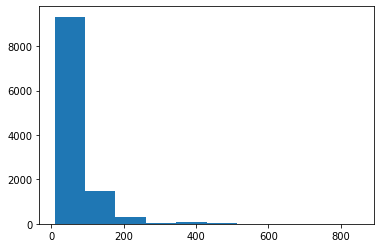

In [16]:
# y un rango para clasificación (del 1 al 3 por ejemplo: barato, normal, caro)
import matplotlib.pyplot as plt
plt.hist(y_reg, bins=10)
plt.show()

In [17]:
y_class = []
for x in y_reg:
    # barato
    if x <= 50:
        y_class.append(0)
    elif x <=150:
        y_class.append(1)
    else:
        y_class.append(2)

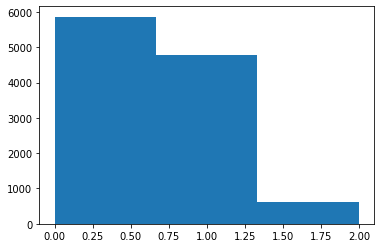

In [18]:
# veamos cómo ha quedado la distribución al convertirla a 3 clases
plt.hist(y_class, bins=3)
plt.show()

In [19]:
print(final_data.shape)
final_data.head(5)

(11268, 89)


,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,12768616,https://www.airbnb.com/rooms/12768616,20170407214050,2017-04-08,Ramblas Studio D,"Unique apartment in vibrant neighborhoods, car...",Centrally located in the atmospheric Gothic Qu...,"Unique apartment in vibrant neighborhoods, car...",none,Located on the edge of the Gothic Quarter of B...,NaN,The nearest station is Place de Catalunya a fe...,NaN,NaN,No pets or smoking allowed.,https://a0.muscache.com/im/pictures/cffe393a-0...,https://a0.muscache.com/im/pictures/cffe393a-0...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/cffe393a-0...,54310958,https://www.airbnb.com/users/show/54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.383887,2.171802,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,349.0,NaN,NaN,NaN,NaN,1,0,2,1125,a week ago,NaN,2,2,2,2,2017-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,92,NaN,"41.3838872822,2.17180232785","Host Has Profile Pic,Host Identity Verified,Is..."
1,1629146,https://www.airbnb.com/rooms/1629146,20170407214050,2017-04-08,"Design, art & vintage / old city","If you're looking for a cool, spacious, light,...",The apartment is very comfortable and very tas...,"If you're looking for a cool, spacious, light,...",none,• A major advantage of this apartment is its l...,• Possibility of offering Premium Services suc...,• Nearest metro station is 1 min walk (Sant A...,Here's a list of of things we provide to our g...,==============================================...,* NO parties are allowed * NO noise on the st...,https://a0.muscache.com/im/pictures/ea919e56-a...,https://a0.muscache.com/im/pictures/ea919e56-a...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ea919e56-a...,8658841,https://www.airbnb.com/users/show/8658841,Olga & Co.,2013-09-05,"Barcelona, Catalonia, Spain","World traveller, currently living and working ...",within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/d67fdad1-e...,https://a0.muscache.com/im/pictures/d67fdad1-e...,El Raval,2.0,2.0,"email,phone,reviews,jumio","El Raval, Barcelona, Catalonia 08001, Spain",El Raval,el Raval,Ciutat Vella,Barcelona,Catalonia,08001,Barcelona,"Barcelona, Spain",ES,Spain,41.382663,2.167558,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"TV,Internet,Wi

In [20]:
df_final = final_data

In [21]:
np.save('df_final.npy', df_final)

In [22]:
# montamos GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!cp df_final.npy /content/drive/My\ Drive/df_final.npy

In [24]:
!ls -lah df_final.npy

-rw-r--r-- 1 root root 41M Jul  3 11:25 df_final.npy


ESTE ES EL DATASET FINAL QUE UTILIZAREMOS PARA LA PRACTICA PARA PODER HACER LAS PRUEBAS CON LOS REGISTROS QUE SIEMPRE TENGAN IMAGENES

In [25]:
data = df_final

ANALISIS EXPLORATORIO

Vemos comos nos daba el dato de la dimension que tenemos muchas columnas (89) y algunas con demasiada informacion de tipo caracter, url...vamos a analizar algo mas detalladamente las columnas para ver en un primer rastreo cual podemos eliminar.

Listamos el ID, nombre y tipo de las columnas para tener localizado a la hora de hacer drop().

In [26]:
for i in range (len(data.columns.values)):
    print("Columna:", i, data.columns.values[i], "es: ", data.iloc[:, i].dtype)

Columna: 0 ID es:  int64
Columna: 1 Listing Url es:  object
Columna: 2 Scrape ID es:  int64
Columna: 3 Last Scraped es:  object
Columna: 4 Name es:  object
Columna: 5 Summary es:  object
Columna: 6 Space es:  object
Columna: 7 Description es:  object
Columna: 8 Experiences Offered es:  object
Columna: 9 Neighborhood Overview es:  object
Columna: 10 Notes es:  object
Columna: 11 Transit es:  object
Columna: 12 Access es:  object
Columna: 13 Interaction es:  object
Columna: 14 House Rules es:  object
Columna: 15 Thumbnail Url es:  object
Columna: 16 Medium Url es:  object
Columna: 17 Picture Url es:  object
Columna: 18 XL Picture Url es:  object
Columna: 19 Host ID es:  int64
Columna: 20 Host URL es:  object
Columna: 21 Host Name es:  object
Columna: 22 Host Since es:  object
Columna: 23 Host Location es:  object
Columna: 24 Host About es:  object
Columna: 25 Host Response Time es:  object
Columna: 26 Host Response Rate es:  float64
Columna: 27 Host Acceptance Rate es:  float64
Columna: 

Con el siguiente proceso intento analizar algo mas cada columna para ver si se trata de url, o que tenga mucha informacion de caracter o que tipo de información numerica nos da, nos fijaremos detenidamente en las variables de tipo 'object' para las que no podamos categorizar por tener demasiada informacion y al escapar aún de todos mis conocimientos las excluyamos.

In [27]:
for i in range (len(data.columns.values)):
    print("-----------------------------------------------")
    print("----------INICIO INFORMACION COLUMNA-----------")
    print('\n',data[data.columns.values[i]].value_counts())
    print("Indice: ",i)
    print("-----------------FIN COLUMNA-------------------")

Se han truncado las últimas 5000 líneas del flujo de salida.
Center - Sol. :: Nice & quiet Apt. WiFi - Heat M32                             1
piso centrico, argüelles                                                       1
Habitación acogedora en La Latina                                              1
Habitación en ático luminoso                                                   1
Blue in Green Melody                                                           1
Bienvenidos aventureros.                                                       1
Bonito piso en el barrio de Salamanca.                                         1
PYR Select  Plaza de España I                                                  1
12min from Sol- Wifi & A/C 6Pax(Max)                                           1
Cosy room in the center of Madrid.                                             1
Modern and reformed room (8) in Sol                                            1
Habitación doble en Madrid Río                  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



https://www.airbnb.com/users/show/54310958     143
https://www.airbnb.com/users/show/15258781      97
https://www.airbnb.com/users/show/3566146       55
https://www.airbnb.com/users/show/21514948      48
https://www.airbnb.com/users/show/4200246       47
https://www.airbnb.com/users/show/5542111       45
https://www.airbnb.com/users/show/27526991      40
https://www.airbnb.com/users/show/1408525       40
https://www.airbnb.com/users/show/117752844     38
https://www.airbnb.com/users/show/30750005      37
https://www.airbnb.com/users/show/21485458      34
https://www.airbnb.com/users/show/28038703      33
https://www.airbnb.com/users/show/1650712       31
https://www.airbnb.com/users/show/2991670       30
https://www.airbnb.com/users/show/96147078      29
https://www.airbnb.com/users/show/89498753      29
https://www.airbnb.com/users/show/117750911     26
https://www.airbnb.com/users/show/8864750       24
https://www.airbnb.com/users/show/7108328       24
https://www.airbnb.com/users/sh

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Se han truncado las últimas 5000 líneas del flujo de salida.
-3.702201    1
-3.700643    1
-3.648327    1
-3.715400    1
-3.702106    1
-3.678404    1
-3.671673    1
-3.685760    1
 2.841446    1
-3.737081    1
-3.695163    1
-3.716005    1
-3.649689    1
-3.713591    1
-3.725609    1
-3.696145    1
-3.706607    1
-3.669848    1
-3.647351    1
-3.731975    1
-3.696095    1
-3.709931    1
-3.710125    1
-3.766313    1
-3.748653    1
-3.708140    1
-3.706408    1
-3.692971    1
-3.697086    1
-3.697799    1
 3.316672    1
-3.701972    1
-3.702556    1
-3.719457    1
-3.695994    1
-3.696886    1
-3.699766    1
-3.669013    1
-3.702570    1
-3.699893    1
-3.701430    1
-3.667592    1
-3.712510    1
-3.652628    1
-3.714112    1
-3.661568    1
-3.693775    1
-3.707186    1
-3.701369    1
-3.695170    1
-3.714643    1
-3.665499    1
-3.704404    1
-3.669851    1
-3.706792    1
-3.701842    1
-3.703930    1
-3.656915    1
-3.696654    1
-3.669881    1
-3.695830    1
-3.714596    1
-3.717914

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 40.4013997301,-3.70015767556    1
40.4137953673,-3.70760239289    1
40.4014697407,-3.69959036371    1
40.4228692223,-3.6961298639     1
40.4167703907,-3.70801527577    1
40.4315024667,-3.71017416922    1
40.4067774917,-3.7077085729     1
40.4598908821,-3.6739389989     1
40.4412410264,-3.69807343513    1
39.575742519,2.64414758694      1
40.4157963146,-3.69589597558    1
40.3946544902,-3.72115920965    1
40.4625506358,-3.67097938446    1
40.424900706,-3.68210895211     1
40.4429475683,-3.67403350712    1
40.4371434092,-3.64015744531    1
40.4151525331,-3.70002733608    1
40.4203885349,-3.7015165771     1
40.4271807769,-3.73232658539    1
40.4210220512,-3.67698918814    1
40.4234058847,-3.71185259148    1
40.4061228245,-3.64799148647    1
40.4220273035,-3.69898051404    1
40.408619243,-3.69723766141     1
40.4212738452,-3.71078481093    1
40.4165850214,-3.71151813574    1
40.4349102247,-3.70915888304    1
40.3907287579,-3.73118152497    1
40.4023678771,-3.70332653816    1
40.408549271

In [28]:
#Esto es por si quiero ver algun indice en concreto si no recuerdo bien la informacion de la columna.

index_col = 52
var_aux_indexName = data.columns.values[index_col]
print(var_aux_indexName)
data[var_aux_indexName].value_counts()

Beds


1.0     5821
2.0     2896
3.0     1203
4.0      684
5.0      257
6.0      153
7.0       63
8.0       55
10.0      39
9.0       19
16.0      13
12.0      11
11.0       5
14.0       5
15.0       3
13.0       2
Name: Beds, dtype: int64

In [29]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,11268.0,1.088120e+07,5.503518e+06,1.986400e+04,6.365029e+06,1.226022e+07,1.572384e+07,1.810984e+07
Scrape ID,11268.0,2.017041e+13,1.155137e+07,2.017032e+13,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13
Host ID,11268.0,3.960989e+07,3.562667e+07,1.985400e+04,8.305342e+06,2.911340e+07,6.180735e+07,1.247534e+08
Host Response Rate,9904.0,9.614247e+01,1.278820e+01,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
Host Acceptance Rate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Host Listings Count,11265.0,1.094860e+01,3.126594e+01,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,2.650000e+02
Host Total Listings Count,11265.0,1.094860e+01,3.126594e+01,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,2.650000e+02
Latitude,11268.0,4.043090e+01,1.811334e-01,3.931747e+01,4.040970e+01,4.041926e+01,4.042953e+01,4.143457e+01
Longitude,11268.0,-3.455200e+00,1.196761e+00,-3.863907e+00,-3.708086e+00,-3.701085e+00,-3.688876e+00,3.467897e+00
Accommodates,11268.0,3.126376e+00,2.010800e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01


Se ve que gran parte de los datos no aportan información relevante o que escapan a mi conocimiento actual. Se van a eliminar de inmediato las columnas:

Listing Url

Scrape ID: no aporta información sobre la propiedad.

Last Scraped: no aporta información sobre la propiedad.

Medium Url

Picture Url

XL Picture Url

Host ID: aporta información sobre el dueño, pero no sobre la propiedad (podría revisarse su inclusión si los resultados no son buenos).

Host Url

Host Name: no aporta información sobre la propiedad. Podría ser de interés estadístico otro tipo de dato categórico del dueño (rango de edad, sexo...) pero no el nombre.

Host Thumbnail Url

Host Picture Url

Host Neighbourhood: no aporta información sobre la propiedad.

Weekly Price: información redundante que puede actuar como predictor (y no debe)

Monthly Price: información redundante que puede actuar como predictor (y no debe)

Calendar Updated: información irrelevante; se podría inferir la frecuencia de actividad del dueño, pero YA hay un dato explícito de su tasa de respuesta.

Calendar last Scraped: no aporta información sobre la propiedad.

First review: no aporta información nueva; ya hay un dato de antiguedad del dueño.

Last review: no aporta información nueva.

Reviews per Month: no aporta información nueva

Geolocation: es latitud + longitud

Host Listings Count, Host Total Listings Count, Calculated host listings count: contador relacionado con el dueño; no aporta información sobre la propiedad.

In [30]:
not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price', 
    'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review', 
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count']

data.drop(not_useful_columns, axis=1, inplace=True)

In [31]:
data.head(5)

,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Features
0,Ramblas Studio D,"Unique apartment in vibrant neighborhoods, car...",Centrally located in the atmospheric Gothic Qu...,"Unique apartment in vibrant neighborhoods, car...",none,Located on the edge of the Gothic Quarter of B...,NaN,The nearest station is Place de Catalunya a fe...,NaN,NaN,No pets or smoking allowed.,https://a0.muscache.com/im/pictures/cffe393a-0...,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.383887,2.171802,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,349.0,NaN,NaN,1,0,2,1125,NaN,2,2,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,"Host Has Profile Pic,Host Identity Verified,Is..."
1,"Design, art & vintage / old city","If you're looking for a cool, spacious, light,...",The apartment is very comfortable and very tas...,"If you're looking for a cool, spacious, light,...",none,• A major advantage of this apartment is its l...,• Possibility of offering Premium Services suc...,• Nearest metro station is 1 min walk (Sant A...,Here's a list of of things we provide to our g...,==============================================...,* NO parties are allowed * NO noise on the st...,https://a0.muscache.com/im/pictures/ea919e56-a...,2013-09-05,"Barcelona, Catalonia, Spain","World traveller, currently living and working ...",within an hour,100.0,NaN,"email,phone,reviews,jumio","El Raval, Barcelona, Catalonia 08001, Spain",El Raval,el Raval,Ciutat Vella,Barcelona,Catalonia,08001,Barcelona,"Barcelona, Spain",ES,Spain,41.382663,2.167558,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",NaN,165.0,150.0,60.0,4,20,3,30,NaN,5,10,22,80,110,93.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,NaN,strict,"Host Has Profile Pic,Host Identity Verified,Re..."
2,Penthouse with terrace in Rambla Catalunya -Ce...,For perfect relaxing time with friend or famil...,This very beautiful and bright apartment is lo...,For perfect relaxing time with friend or famil...,none,"Located in the real center of the city, close ...",HUTB-(PHONE NUMBER HIDDEN),"Easy access by subway , airport and city buses...",NaN,We offer to our guests an individual and perso...,-Smoking allowed on balcony only. -When you l...,https://a0.muscache.com/im/pictures/57011236/e...,2012-08-28,"Barcelona, Cataluña, Spain","Dear travelers, \r\nMany years ago we moved fr...",within a few hours,99.0,NaN,"email,phone,facebook,google,reviews,jumio,work...","Dreta de l'Eixample, Barcelona, Catalonia 0800...",Dreta de l'Eixample,la Dreta de l'Eixample,Eixample,Barcelona,Catalonia,08007,Barcelona,"Barcelona, Spain",ES,Spain,41.388467,2.168451,Apartment,Entire home/apt,5,1.0,2.0,2.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",NaN,129.0,200.0,75.0,3,20,2,60,NaN,2,5,10,230,89,94.0,10.0,10.0,10.0,10.0,10.0,9.0,HUTB-007975-96,NaN,moderate,"Host Has

Y luego hay una serie de columnas que, si bien aportan mucha información, exigen un tratamiento previo que queda fuera del alcance de este trabajo. Name, summary, description... exigirían tokenización y un análisis con NLP para poder sacar algo en claro, de modo que se eliminan.

In [32]:
# Hacemos un drop de todas las columnas que aportando información quedan fuera del scope
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About']

data.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)

In [33]:
data.shape

(11268, 53)

Se analiza el número de valores diferentes por columnas.

In [34]:
print("----------INICIO INFORMACION-----------")
print('\n',data.apply(lambda x: len(x.unique())))
print("-----------------FIN-------------------")

----------INICIO INFORMACION-----------

 Experiences Offered                 1
Thumbnail Url                   11265
Host Since                       1975
Host Response Time                  5
Host Response Rate                 62
Host Acceptance Rate                1
Host Verifications                182
Street                            917
Neighbourhood                      96
Neighbourhood Cleansed            189
Neighbourhood Group Cleansed       31
City                               99
State                              37
Zipcode                           174
Market                              8
Smart Location                    103
Country Code                        1
Country                             1
Latitude                        11268
Longitude                       11268
Property Type                      22
Room Type                           3
Accommodates                       16
Bathrooms                          17
Bedrooms                           11
Beds    

La variable Street no muestra realmente la calle; en muchas, simplemente es la ciudad y un código postal (variables que ya tienen su propia columna). Es una variable muy ruidosa y no categorizada.

Por otro lado, City, State, Market y Smart Location aportan la misma información, al igual que Country y Country Code y de forma similar a Neighbourhood y Zipcode. Este paso es controvertido; es aventurado eliminar sin más estas columnas. Sin embargo, es válido para una primera aproximación. Nos quedamos con City y eliminamos las demás.

In [35]:
data.drop(['Street', 'State', 'Market', 'Smart Location', 'Country', 'Zipcode'], axis=1, inplace=True)

Por último se comprueba qué variables tienen muchos valores missing (NaN or null). Hay columnas en las que apenas hay datos. De un total de unos 9000 registros, columnas como Host Acceptance Rate o Square Feet tienen más de un 80% de valores vacíos. No es conveniente imputar valores, ya que no hay una muestra significativa para extraer medias. Se hace drop de las columnas con muchos valores NaN.

In [36]:
print(f'El dataframe tiene un total de {len(data)} filas.')
len(data) - data.count() # vemos cuántos valores NaN hay por columna

El dataframe tiene un total de 11268 filas.


Experiences Offered                 0
Thumbnail Url                       0
Host Since                          3
Host Response Time               1364
Host Response Rate               1364
Host Acceptance Rate            11268
Host Verifications                  3
Neighbourhood                    4057
Neighbourhood Cleansed              0
Neighbourhood Group Cleansed      180
City                                5
Country Code                        0
Latitude                            0
Longitude                           0
Property Type                       0
Room Type                           0
Accommodates                        0
Bathrooms                          37
Bedrooms                           22
Beds                               39
Bed Type                            0
Amenities                         129
Square Feet                     10866
Price                               4
Security Deposit                 6611
Cleaning Fee                     4702
Guests Inclu

In [37]:
data.isnull().any()

Experiences Offered             False
Thumbnail Url                   False
Host Since                       True
Host Response Time               True
Host Response Rate               True
Host Acceptance Rate             True
Host Verifications               True
Neighbourhood                    True
Neighbourhood Cleansed          False
Neighbourhood Group Cleansed     True
City                             True
Country Code                    False
Latitude                        False
Longitude                       False
Property Type                   False
Room Type                       False
Accommodates                    False
Bathrooms                        True
Bedrooms                         True
Beds                             True
Bed Type                        False
Amenities                        True
Square Feet                      True
Price                            True
Security Deposit                 True
Cleaning Fee                     True
Guests Inclu

In [38]:
columns_with_too_many_missing_values = [
    'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names']

data.drop(columns_with_too_many_missing_values, axis=1, inplace=True)

In [39]:
data.shape

(11268, 42)

VARIABLES REDUNDANTES

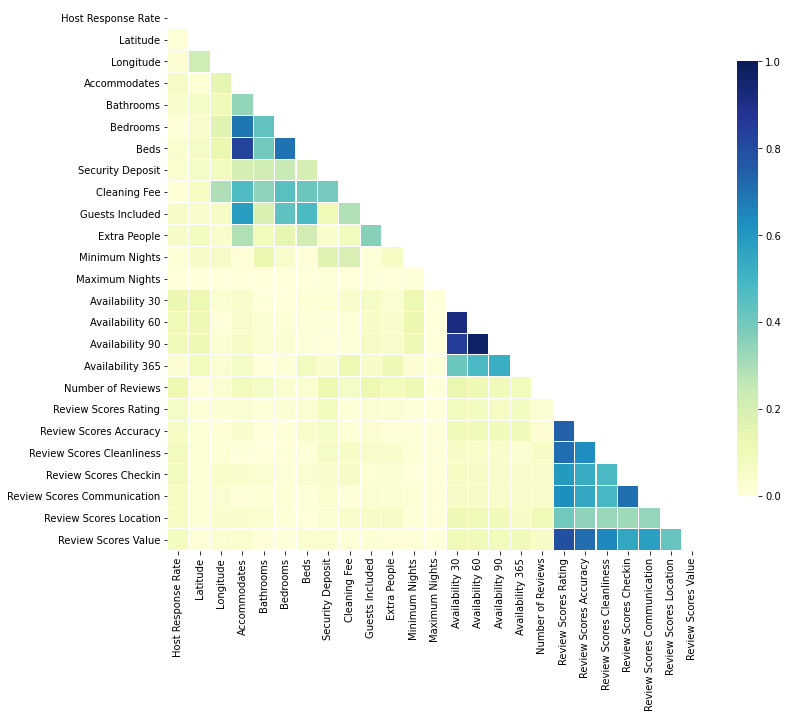

In [40]:
# Compute the correlation matrix
corr = np.abs(data.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# puedo representar solo la parte inferior ya que es simétrica

Vemos que hay mucha correlación entre las variables de availability y las de reviews. Podemos eliminar todas las availability salvo 365 y hacer una media de las de review; he decidido hacer media porque son reviews, pero podría escogerse otra estrategia, o incluso conservarlas todas ya que técnicamente no hacen referencia a la misma info. Eliminamos también Accommodates que tiene correlación alta con Beds.

In [41]:
reviews = data.loc[: , "Review Scores Rating":"Review Scores Value"]
data['Average Review'] = reviews.mean(axis=1)

data.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating', 
         'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
        'Accommodates'], axis=1, inplace=True)

In [42]:
data.shape

(11268, 32)

Por último, podemos hacer una representación (scatter_plot) de todas las variables frente al resto, para tener una idea de cómo se relacionan las variables del problema

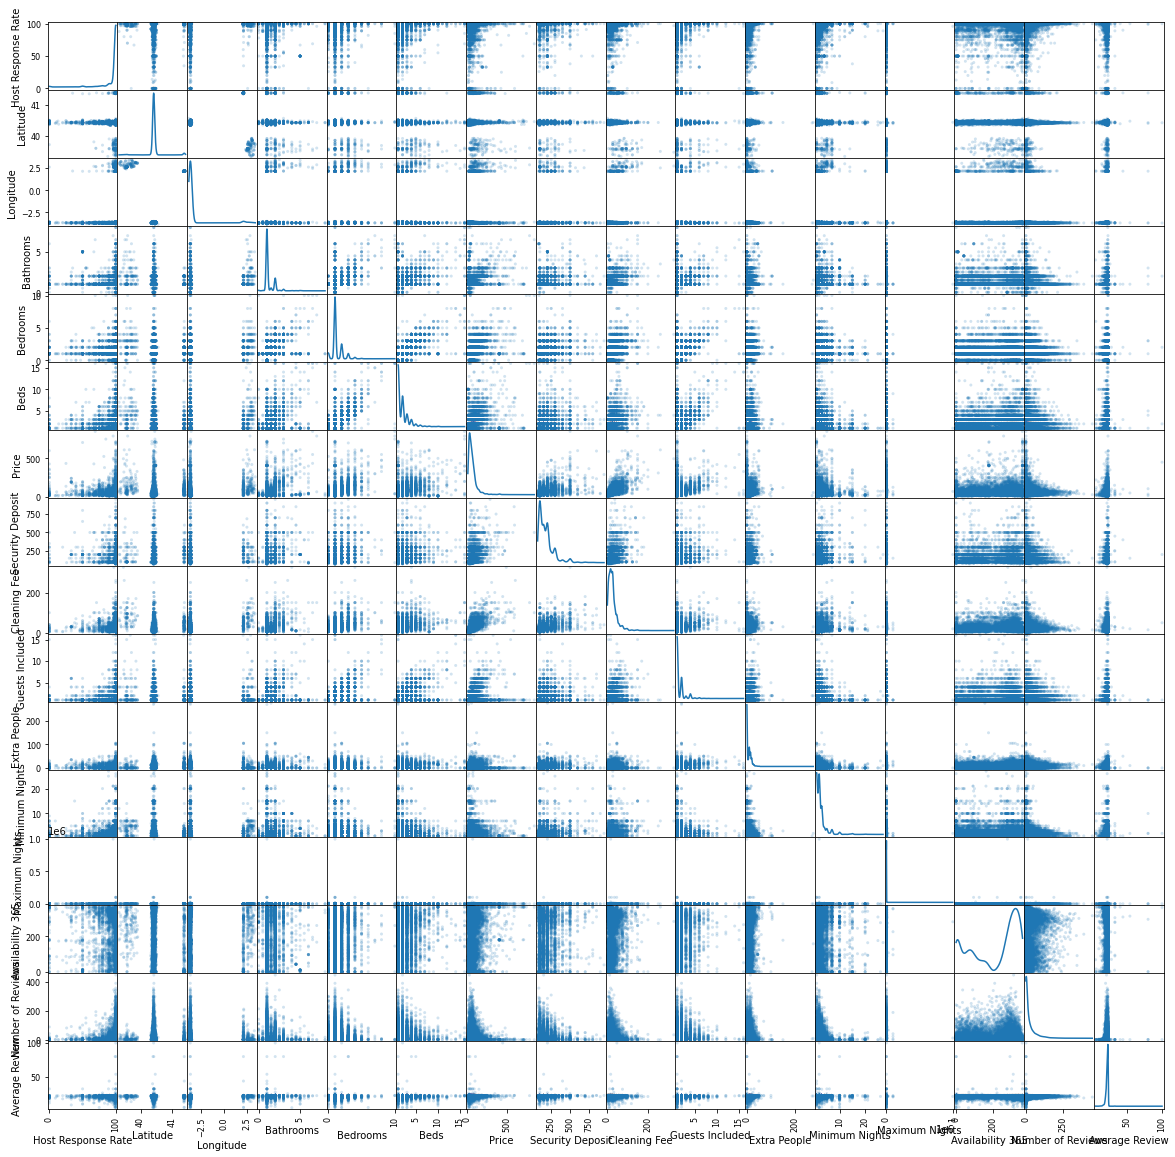

In [43]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

In [44]:
for i in range (len(data.columns.values)):
    print("Columna:", i, data.columns.values[i], "es: ", data.iloc[:, i].dtype)

Columna: 0 Experiences Offered es:  object
Columna: 1 Thumbnail Url es:  object
Columna: 2 Host Since es:  object
Columna: 3 Host Response Time es:  object
Columna: 4 Host Response Rate es:  float64
Columna: 5 Host Verifications es:  object
Columna: 6 Neighbourhood es:  object
Columna: 7 Neighbourhood Cleansed es:  object
Columna: 8 Neighbourhood Group Cleansed es:  object
Columna: 9 City es:  object
Columna: 10 Country Code es:  object
Columna: 11 Latitude es:  float64
Columna: 12 Longitude es:  float64
Columna: 13 Property Type es:  object
Columna: 14 Room Type es:  object
Columna: 15 Bathrooms es:  float64
Columna: 16 Bedrooms es:  float64
Columna: 17 Beds es:  float64
Columna: 18 Bed Type es:  object
Columna: 19 Amenities es:  object
Columna: 20 Price es:  float64
Columna: 21 Security Deposit es:  float64
Columna: 22 Cleaning Fee es:  float64
Columna: 23 Guests Included es:  int64
Columna: 24 Extra People es:  int64
Columna: 25 Minimum Nights es:  int64
Columna: 26 Maximum Nights e

Host Verifications, Features y Amenities exigirían un análisis NLP, pero hay información directa que se puede extraer. Todas son listas, separadas por comas. Se puede contar el número de elementos en cada lista y usarlo como característica.

In [45]:
df_l = data[['Features', 'Amenities', 'Host Verifications']]
df_l.fillna("", inplace=True) # rellenamos los huecos con cadenas vacías

df_l['Features'] = df_l['Features'].apply(lambda x: len(str(x).split(',')))
df_l['Amenities'] = df_l['Amenities'].apply(lambda x: len(str(x).split(',')))
df_l['Host Verifications'] = df_l['Host Verifications'].apply(lambda x: len(str(x).split(',')))

df_l.head(10)

,Features,Amenities,Host Verifications
0,4,8,4
1,5,23,4
2,4,13,7
3,5,9,4
4,5,9,4
5,3,15,4
6,5,20,5
7,2,7,3
8,3,7,4
9,5,6,4


Aplicamos al dataset original:

In [46]:
data['Features'].fillna("", inplace=True)
data['Amenities'].fillna("", inplace=True)
data['Host Verifications'].fillna("", inplace=True)

data['Features'] = data['Features'].apply(lambda x: len(str(x).split(',')))
data['Amenities'] = data['Amenities'].apply(lambda x: len(str(x).split(',')))
data['Host Verifications'] = data['Host Verifications'].apply(lambda x: len(str(x).split(',')))

In [47]:
data.columns

Index(['Experiences Offered', 'Thumbnail Url', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Host Verifications',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'Country Code', 'Latitude',
       'Longitude', 'Property Type', 'Room Type', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Price', 'Security Deposit',
       'Cleaning Fee', 'Guests Included', 'Extra People', 'Minimum Nights',
       'Maximum Nights', 'Availability 365', 'Number of Reviews',
       'Cancellation Policy', 'Features', 'Average Review'],
      dtype='object')

In [48]:
columnas_numericas = ['Host Response Rate', 'Host Verifications', 'Latitude', 'Longitude', 'Bathrooms',
       'Bedrooms', 'Beds', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People','Minimum Nights','Maximum Nights','Availability 365','Number of Reviews','Average Review', 'Amenities', 'Features']
data_numerica = data.loc[:, columnas_numericas]
data_numerica.shape

(11268, 18)

In [49]:
data_numerica.head(5)

,Host Response Rate,Host Verifications,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Average Review,Amenities,Features
0,99.0,4,41.383887,2.171802,1.0,0.0,1.0,NaN,NaN,1,0,2,1125,2,0,NaN,8,4
1,100.0,4,41.382663,2.167558,1.0,2.0,3.0,150.0,60.0,4,20,3,30,80,110,21.285714,23,5
2,99.0,7,41.388467,2.168451,1.0,2.0,2.0,200.0,75.0,3,20,2,60,230,89,21.857143,13,4
3,99.0,4,41.402586,2.176946,1.0,2.0,2.0,300.0,15.0,1,0,2,1125,2,1,22.571429,9,5
4,99.0,4,41.405006,2.173369,1.0,2.0,3.0,NaN,NaN,1,0,2,1125,0,5,22.428571,9,5


**Estandarizamos variables numéricas**

In [50]:
# Estandarizamos los valores
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_scaler = scaler.fit_transform(data_numerica)

In [51]:
data_numerica.iloc[:] = numerical_scaler
print(data_numerica.shape)
data_numerica.head(5)

(11268, 18)


,Host Response Rate,Host Verifications,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Average Review,Amenities,Features
0,0.223462,-0.107928,5.261489,4.702067,-0.422489,-1.556053,-0.626389,NaN,NaN,-0.497410,-0.710413,-0.191147,0.015005,-1.577334,-0.618677,NaN,-1.303676,0.185775
1,0.301663,-0.107928,5.254728,4.698521,-0.422489,0.835388,0.663019,-0.294284,1.439799,2.166898,1.263555,0.260866,-0.098341,-0.960666,2.106328,-0.023573,1.776769,1.142059
2,0.223462,2.153953,5.286775,4.699267,-0.422489,0.835388,0.018315,0.187740,2.128210,1.278795,1.263555,-0.191147,-0.095236,0.225234,1.586100,0.231096,-0.276861,0.185775
3,0.223462,-0.107928,5.364726,4.706365,-0.422489,0.835388,0.018315,1.151789,-0.625434,-0.497410,-0.710413,-0.191147,0.015005,-1.577334,-0.593905,0.549433,-1.098313,1.142059
4,0.223462,-0.107928,5.378086,4.703376,-0.422489,0.835388,0.663019,NaN,NaN,-0.497410,-0.710413,-0.191147,0.015005,-1.593146,-0.494814,0.485766,-1.098313,1.142059


Parece curioso que haya tres variables diferentes con información sobre el vecindario; a ver qué pasa si se muestran más filas:

In [52]:
df_n = data[['Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']]
df_n.head(20)

,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed
0,El Gòtic,el Barri Gòtic,Ciutat Vella
1,El Raval,el Raval,Ciutat Vella
2,Dreta de l'Eixample,la Dreta de l'Eixample,Eixample
3,La Sagrada Família,la Sagrada Família,Eixample
4,La Sagrada Família,la Sagrada Família,Eixample
5,Sants-Montjuïc,el Poble Sec,Sants-Montjuïc
6,Les Corts (Nabe),les Corts,Les Corts
7,NaN,el Camp d'en Grassot i Gràcia Nova,Gràcia
8,Camp d'en Grassot i Gràcia Nova,el Camp d'en Grassot i Gràcia Nova,Gràcia
9,El Camp de l'Arpa del Clot,el Camp de l'Arpa del Clot,Sant Martí


Parece que va de más detalle a menos. Si observamos los valores únicos de cada columna se ve que cleansed no tiene valores missing:

In [53]:
print(f'El dataframe tiene un total de {len(df_n)} filas.')
len(df_n) - df_n.count() # vemos cuántos valores NaN hay por columna

El dataframe tiene un total de 11268 filas.


Neighbourhood                   4057
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed     180
dtype: int64

Pero a cambio tiene muchos más valores diferentes:

In [54]:
df_n.apply(lambda x: len(x.unique())) # vemos el número de valores distintos por columna

Neighbourhood                    96
Neighbourhood Cleansed          189
Neighbourhood Group Cleansed     31
dtype: int64

Se va a usar Neighbourhood Group Cleansed a no ser que sea NaN/Null; en ese caso se rellenará con Neighbourhood Cleansed

In [55]:
df_n["Final Neighbourhood"] = df_n["Neighbourhood Group Cleansed"].fillna(df_n["Neighbourhood Cleansed"])

In [56]:
len(df_n) - df_n.count() # Final neighbourhood no tiene valores missing

Neighbourhood                   4057
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed     180
Final Neighbourhood                0
dtype: int64

In [57]:
df_n.apply(lambda x: len(x.unique())) # y aunque tiene más valores diferentes que group cleansed, tiene menos que cleansed

Neighbourhood                    96
Neighbourhood Cleansed          189
Neighbourhood Group Cleansed     31
Final Neighbourhood              60
dtype: int64

Aplicamos al dataset original y eliminamos las tres columnas de neighbourhood:

In [58]:
data["Final Neighbourhood"] = data["Neighbourhood Group Cleansed"].fillna(data["Neighbourhood Cleansed"])
data.drop(["Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"], axis=1, inplace=True)

Se ve que las columnas no numéricas que quedan son:

In [59]:
list(data.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Thumbnail Url',
 'Host Since',
 'Host Response Time',
 'City',
 'Country Code',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy',
 'Final Neighbourhood']

In [60]:
df_nn = data[list(data.select_dtypes(include=['object']).columns)]
df_nn.apply(lambda x: len(x.unique())) # valores diferentes

Experiences Offered        1
Thumbnail Url          11265
Host Since              1975
Host Response Time         5
City                      99
Country Code               1
Property Type             22
Room Type                  3
Bed Type                   5
Cancellation Policy        5
Final Neighbourhood       60
dtype: int64

Vemos que la columna 'Experiences Offered' tiene un solo valor unico y todos a 'none' procedemos a eliminarla.

Vemos que la columna 'Country Code' tiene un solo valor unico y todos son 'ES' procedemos a eliminarla.

In [61]:
data.drop(['Experiences Offered', 'Country Code'], axis=1, inplace=True)

In [62]:
data.shape

(11268, 28)

In [63]:
for i in range (len(data.columns.values)):
    print("Columna:", i, data.columns.values[i], "es: ", data.iloc[:, i].dtype)

Columna: 0 Thumbnail Url es:  object
Columna: 1 Host Since es:  object
Columna: 2 Host Response Time es:  object
Columna: 3 Host Response Rate es:  float64
Columna: 4 Host Verifications es:  int64
Columna: 5 City es:  object
Columna: 6 Latitude es:  float64
Columna: 7 Longitude es:  float64
Columna: 8 Property Type es:  object
Columna: 9 Room Type es:  object
Columna: 10 Bathrooms es:  float64
Columna: 11 Bedrooms es:  float64
Columna: 12 Beds es:  float64
Columna: 13 Bed Type es:  object
Columna: 14 Amenities es:  int64
Columna: 15 Price es:  float64
Columna: 16 Security Deposit es:  float64
Columna: 17 Cleaning Fee es:  float64
Columna: 18 Guests Included es:  int64
Columna: 19 Extra People es:  int64
Columna: 20 Minimum Nights es:  int64
Columna: 21 Maximum Nights es:  int64
Columna: 22 Availability 365 es:  int64
Columna: 23 Number of Reviews es:  int64
Columna: 24 Cancellation Policy es:  object
Columna: 25 Features es:  int64
Columna: 26 Average Review es:  float64
Columna: 27 Fi

Realizamos drop de las variables de tipo object que no vamos a categorizar y que tienen muchos valores unicos:

Thumbnail Url

Host Since

City

In [64]:
df_nn = data[list(data.select_dtypes(include=['object']).columns)]
df_nn.apply(lambda x: len(x.unique())) # valores diferentes

Thumbnail Url          11265
Host Since              1975
Host Response Time         5
City                      99
Property Type             22
Room Type                  3
Bed Type                   5
Cancellation Policy        5
Final Neighbourhood       60
dtype: int64

In [65]:
data.drop(['Thumbnail Url', 'Host Since', 'City'], axis=1, inplace=True)

In [66]:
data.head(5)

,Host Response Time,Host Response Rate,Host Verifications,Latitude,Longitude,Property Type,Room Type,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Cancellation Policy,Features,Average Review,Final Neighbourhood
0,within an hour,99.0,4,41.383887,2.171802,Apartment,Entire home/apt,1.0,0.0,1.0,Real Bed,8,349.0,NaN,NaN,1,0,2,1125,2,0,strict,4,NaN,Ciutat Vella
1,within an hour,100.0,4,41.382663,2.167558,Apartment,Entire home/apt,1.0,2.0,3.0,Real Bed,23,165.0,150.0,60.0,4,20,3,30,80,110,strict,5,21.285714,Ciutat Vella
2,within a few hours,99.0,7,41.388467,2.168451,Apartment,Entire home/apt,1.0,2.0,2.0,Real Bed,13,129.0,200.0,75.0,3,20,2,60,230,89,moderate,4,21.857143,Eixample
3,within an hour,99.0,4,41.402586,2.176946,Apartment,Entire home/apt,1.0,2.0,2.0,Real Bed,9,90.0,300.0,15.0,1,0,2,1125,2,1,strict,5,22.571429,Eixample
4,within an hour,99.0,4,41.405006,2.173369,Apartment,Entire home/apt,1.0,2.0,3.0,Real Bed,9,89.0,NaN,NaN,1,0,2,1125,0,5,strict,5,22.428571,Eixample


**IMPUTAR VALORES**

In [67]:
# tratamos los NaNs
data.isna().sum()

Host Response Time     1364
Host Response Rate     1364
Host Verifications        0
Latitude                  0
Longitude                 0
Property Type             0
Room Type                 0
Bathrooms                37
Bedrooms                 22
Beds                     39
Bed Type                  0
Amenities                 0
Price                     4
Security Deposit       6611
Cleaning Fee           4702
Guests Included           0
Extra People              0
Minimum Nights            0
Maximum Nights            0
Availability 365          0
Number of Reviews         0
Cancellation Policy       0
Features                  0
Average Review         2420
Final Neighbourhood       0
dtype: int64

En la siguiente columna vamos a rellenar con la opcion mas frecuente.

In [68]:
data["Host Response Time"].fillna(data["Host Response Time"].mode()[0], inplace=True)

Los siguientes campos los vamos a rellenar con la media.

In [69]:
data['Host Response Rate'] = data['Host Response Rate'].fillna(data['Host Response Rate'].mean())
data['Bathrooms'] = data['Bathrooms'].fillna(data['Bathrooms'].mean())
data['Bedrooms'] = data['Bedrooms'].fillna(data['Bedrooms'].mean())
data['Beds'] = data['Beds'].fillna(data['Beds'].mean())
data['Price'] = data['Price'].fillna(data['Price'].mean())
data['Average Review'] = data['Average Review'].fillna(data['Average Review'].mean())

Las siguientes columnas las vamos a rellenar con 0 al entender que si no disponen de dicha informacion, no corresponderia rellenar con la media.

In [70]:
data['Security Deposit'].fillna(0, inplace=True)
data['Cleaning Fee'].fillna(0, inplace=True)

In [71]:
data.isna().sum()

Host Response Time     0
Host Response Rate     0
Host Verifications     0
Latitude               0
Longitude              0
Property Type          0
Room Type              0
Bathrooms              0
Bedrooms               0
Beds                   0
Bed Type               0
Amenities              0
Price                  0
Security Deposit       0
Cleaning Fee           0
Guests Included        0
Extra People           0
Minimum Nights         0
Maximum Nights         0
Availability 365       0
Number of Reviews      0
Cancellation Policy    0
Features               0
Average Review         0
Final Neighbourhood    0
dtype: int64

In [72]:
list(data.select_dtypes(include=['float64', 'int64']).columns)

['Host Response Rate',
 'Host Verifications',
 'Latitude',
 'Longitude',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Amenities',
 'Price',
 'Security Deposit',
 'Cleaning Fee',
 'Guests Included',
 'Extra People',
 'Minimum Nights',
 'Maximum Nights',
 'Availability 365',
 'Number of Reviews',
 'Features',
 'Average Review']

In [73]:
columnas_numericas = list(data.select_dtypes(include=['float64', 'int64']).columns)
data_numerica = data.loc[:, columnas_numericas]
data_numerica.shape

(11268, 19)

In [74]:
data_numerica.head(5)

,Host Response Rate,Host Verifications,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Features,Average Review
0,99.0,4,41.383887,2.171802,1.0,0.0,1.0,8,349.0,0.0,0.0,1,0,2,1125,2,0,4,21.338608
1,100.0,4,41.382663,2.167558,1.0,2.0,3.0,23,165.0,150.0,60.0,4,20,3,30,80,110,5,21.285714
2,99.0,7,41.388467,2.168451,1.0,2.0,2.0,13,129.0,200.0,75.0,3,20,2,60,230,89,4,21.857143
3,99.0,4,41.402586,2.176946,1.0,2.0,2.0,9,90.0,300.0,15.0,1,0,2,1125,2,1,5,22.571429
4,99.0,4,41.405006,2.173369,1.0,2.0,3.0,9,89.0,0.0,0.0,1,0,2,1125,0,5,5,22.428571


**PROCESAMOS VARIABLES CATEGORICAS**

In [75]:
columnas_categoricas = list(data.select_dtypes(include=['object']).columns)

In [76]:
columnas_categoricas = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy',
 'Final Neighbourhood', 'Price']

In [77]:
data_categorica = data.loc[:, columnas_categoricas]
data_categorica.head(5)

,Host Response Time,Property Type,Room Type,Bed Type,Cancellation Policy,Final Neighbourhood,Price
0,within an hour,Apartment,Entire home/apt,Real Bed,strict,Ciutat Vella,349.0
1,within an hour,Apartment,Entire home/apt,Real Bed,strict,Ciutat Vella,165.0
2,within a few hours,Apartment,Entire home/apt,Real Bed,moderate,Eixample,129.0
3,within an hour,Apartment,Entire home/apt,Real Bed,strict,Eixample,90.0
4,within an hour,Apartment,Entire home/apt,Real Bed,strict,Eixample,89.0


In [78]:
categorical = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy',
 'Final Neighbourhood', 'Price']

#Ahora podemos aplicar un encoder sobre las variables categóricas.
#Aplicamos un smoother extraído [del tutorial de Max Halford](https://maxhalford.github.io/blog/target-encoding-done-the-right-way/),

for c in categorical:
    mean = data_categorica.groupby(c)['Price'].mean()
    data_categorica[c] = data_categorica[c].map(mean)    
    mean_map[c] = mean

In [79]:
data_categorica.drop(['Price'], axis=1, inplace=True)
data_categorica.shape

(11268, 6)

In [80]:
data = pd.concat([data_numerica, data_categorica], axis=1, join='inner')
print(data.shape)

(11268, 25)


In [81]:
print(data.shape)
data.describe()

(11268, 25)


,Host Response Rate,Host Verifications,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Features,Average Review,Host Response Time,Property Type,Room Type,Bed Type,Cancellation Policy,Final Neighbourhood
count,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000,11268.000000
mean,96.142468,4.143149,40.430898,-3.455200,1.264936,1.301352,1.971591,14.348154,65.977717,74.610312,16.681754,1.560082,7.197817,2.422879,980.042865,201.511005,24.974086,3.805733,21.338608,65.977717,65.977717,65.977717,65.977717,65.977717,65.977717
std,11.989160,1.326388,0.181133,1.196761,0.626083,0.835536,1.548481,4.869644,63.006048,111.132495,21.816954,1.126046,10.132328,2.212425,9661.121164,126.491814,40.368682,1.045760,1.988398,4.113729,8.294944,24.291321,2.636349,6.431852,19.843430
min,0.000000,1.000000,39.317472,-3.863907,0.000000,0.000000,1.000000,1.000000,9.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,4.857143,58.283797,17.000000,29.843575,37.321429,60.341979,24.000000
25%,96.142468,3.000000,40.409697,-3.708086,1.000000,1.000000,1.000000,11.000000,30.000000,0.000000,0.000000,1.000000,0.000000,1.000000,365.000000,80.000000,1.000000,3.000000,21.000000,61.262630,66.297237,39.084416,66.346097,60.341979,58.971098
50%,100.000000,4.000000,40.419259,-3.701085,1.000000,1.000000,1.000000,14.000000,50.000000,0.000000,10.000000,1.000000,0.000000,2.000000,1125.000000,235.000000,8.000000,4.000000,21.338608,67.804851,66.297237,87.601585,66.346097,61.640080,67.417678
75%,100.000000,5.000000,40.429526,-3.688876,1.000000,1.000000,2.000000,18.000000,80.000000,150.000000,29.000000,2.000000,12.000000,3.000000,1125.000000,317.000000,31.000000,4.000000,22.285714,67.804851,66.297237,87.601585,66.346097,73.920321,67.888259
max,100.000000,10.000000,41.434567,3.467897,8.000000,10.000000,16.000000,34.000000,850.000000,950.000000,325.000000,16.000000,276.000000,27.000000,1000000.000000,365.000000,446.000000,8.000000,100.000000,85.248075,255.333333,87.601585,66.346097,96.388889,341.000000


In [82]:
data.drop(['Price'], axis=1, inplace=True)

**CLASIFICACION DATASET NUMERICO**

In [83]:
# Vamos a normalizar entre 0 y 1
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(data)
# en este caso no es necesario normalizar las etiquetas, ya que son valores de 0 a N_Clases

In [84]:
# convertimos las etiquetas a onehot
from keras.utils import to_categorical
y_class_onehot = to_categorical(y_class)

# Vamos a dividir en train y en test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_norm, y_class_onehot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

Using TensorFlow backend.


In [85]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2


model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 clases

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 5s 572us/step - loss: 0.5759 - accuracy: 0.7819 - val_loss: 0.5052 - val_accuracy: 0.7871
Epoch 2/50
8112/8112 [==============================] - 3s 366us/step - loss: 0.5015 - accuracy: 0.8003 - val_loss: 0.4860 - val_accuracy: 0.7982
Epoch 3/50
8112/8112 [==============================] - 3s 366us/step - loss: 0.4840 - accuracy: 0.8067 - val_loss: 0.4603 - val_accuracy: 0.8016
Epoch 4/50
8112/8112 [==============================] - 3s 370us/step - loss: 0.4675 - accuracy: 0.8092 - val_loss: 0.4432 - val_accuracy: 0.8093
Epoch 5/50
8112/8112 [==============================] - 3s 366us/step - loss: 0.4585 - accuracy: 0.8110 - val_loss: 0.4488 - val_accuracy: 0.8082
Epoch 6/50
8112/8112 [==============================] - 3s 375us/step - loss: 0.4508 - accuracy: 0.8166 - val_loss: 0.4359 - val_accuracy: 0.8115
Epoch 7/50
8112/8112 [==============================] - 3s 402us/step - loss:

Probamos a incluir una regularizacion L2

In [86]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(3, activation='softmax'))  # 3 clases

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 3s 391us/step - loss: 0.6856 - accuracy: 0.7806 - val_loss: 0.5992 - val_accuracy: 0.7816
Epoch 2/50
8112/8112 [==============================] - 3s 370us/step - loss: 0.5561 - accuracy: 0.7983 - val_loss: 0.5362 - val_accuracy: 0.7916
Epoch 3/50
8112/8112 [==============================] - 3s 395us/step - loss: 0.5330 - accuracy: 0.7976 - val_loss: 0.5647 - val_accuracy: 0.7894
Epoch 4/50
8112/8112 [==============================] - 3s 405us/step - loss: 0.5181 - accuracy: 0.8054 - val_loss: 0.5094 - val_accuracy: 0.8038
Epoch 5/50
8112/8112 [==============================] - 3s 396us/step - loss: 0.5056 - accuracy: 0.8056 - val_loss: 0.4961 - val_accuracy: 0.8093
Epoch 6/50
8112/8112 [==============================] - 3s 371us/step - loss: 0.4988 - accuracy: 0.8093 - val_loss: 0.4806 - val_accuracy: 0.8004
Epoch 7/50
8112/8112 [==============================] - 3s 402us/step - loss:

Aumentamos la complejidad del modelo

In [87]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(3, activation='softmax'))  # tenemos 3 clases

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 3s 422us/step - loss: 0.7704 - accuracy: 0.7845 - val_loss: 0.6210 - val_accuracy: 0.7761
Epoch 2/50
8112/8112 [==============================] - 3s 400us/step - loss: 0.5737 - accuracy: 0.8005 - val_loss: 0.5546 - val_accuracy: 0.7927
Epoch 3/50
8112/8112 [==============================] - 3s 412us/step - loss: 0.5473 - accuracy: 0.7984 - val_loss: 0.5331 - val_accuracy: 0.7949
Epoch 4/50
8112/8112 [==============================] - 3s 415us/step - loss: 0.5360 - accuracy: 0.8015 - val_loss: 0.5435 - val_accuracy: 0.7971
Epoch 5/50
8112/8112 [==============================] - 3s 398us/step - loss: 0.5222 - accuracy: 0.8044 - val_loss: 0.5150 - val_accuracy: 0.7993
Epoch 6/50
8112/8112 [==============================] - 4s 437us/step - loss: 0.5110 - accuracy: 0.8093 - val_loss: 0.4963 - val_accuracy: 0.7993
Epoch 7/50
8112/8112 [==============================] - 4s 444us/step - loss:

Comprobamos con test nuestro modelo final

In [88]:
loss, acc = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')

2254/2254 [==============================] - 0s 50us/step
Loss=0.4408694936992219, Acc=0.8283052444458008


EXPLICACION CLASIFICACION NUMERICA --> Obtenemos un accuracy de 82.83%, hemos intentando aumentar la complejidad, incluir regularizacion pero los datos no parece que varien mucho. Al final hemos decidido optar por el modelo mas complejo con regularizacion como modelo final.

**REGRESION DATOS NUMERICO**


In [89]:
min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(data)
y_reg_norm = (y_reg - y_reg.min()) / (y_reg.max() - y_reg.min())

In [90]:
X_train, X_test, y_train, y_test = train_test_split(data_norm, y_reg_norm.values, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [91]:
model = Sequential()
model.add(Dense(8, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(4, activation="relu"))
# check to see if the regression node should be added
#if regress:
model.add(Dense(1, activation="linear"))

model.compile(loss='mean_absolute_error', optimizer='RMSProp')
 
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 2s 290us/step - loss: nan - val_loss: 0.0318
Epoch 2/50
8112/8112 [==============================] - 2s 272us/step - loss: nan - val_loss: 0.0293
Epoch 3/50
8112/8112 [==============================] - 2s 290us/step - loss: nan - val_loss: 0.0281
Epoch 4/50
8112/8112 [==============================] - 2s 296us/step - loss: nan - val_loss: 0.0281
Epoch 5/50
8112/8112 [==============================] - 2s 297us/step - loss: nan - val_loss: 0.0273
Epoch 6/50
8112/8112 [==============================] - 2s 296us/step - loss: nan - val_loss: 0.0277
Epoch 7/50
8112/8112 [==============================] - 2s 290us/step - loss: nan - val_loss: 0.0267
Epoch 8/50
8112/8112 [==============================] - 2s 288us/step - loss: nan - val_loss: 0.0269
Epoch 9/50
8112/8112 [==============================] - 2s 280us/step - loss: nan - val_loss: 0.0261
Epoch 10/50
8112/8112 [=====================

In [92]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='linear'))  # sin funcion de act y solo 1 neurona

model.compile(loss='mean_absolute_error', optimizer='RMSProp')

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 2s 288us/step - loss: nan - val_loss: 0.0304
Epoch 2/50
8112/8112 [==============================] - 2s 274us/step - loss: nan - val_loss: 0.0255
Epoch 3/50
8112/8112 [==============================] - 2s 278us/step - loss: nan - val_loss: 0.0244
Epoch 4/50
8112/8112 [==============================] - 2s 278us/step - loss: nan - val_loss: 0.0259
Epoch 5/50
8112/8112 [==============================] - 2s 277us/step - loss: nan - val_loss: 0.0240
Epoch 6/50
8112/8112 [==============================] - 2s 283us/step - loss: nan - val_loss: 0.0239
Epoch 7/50
8112/8112 [==============================] - 2s 281us/step - loss: nan - val_loss: 0.0234
Epoch 8/50
8112/8112 [==============================] - 2s 288us/step - loss: nan - val_loss: 0.0229
Epoch 9/50
8112/8112 [==============================] - 2s 276us/step - loss: nan - val_loss: 0.0237
Epoch 10/50
8112/8112 [=====================

In [93]:
loss = model.evaluate(X_test, y_test)
print(f'Loss={loss}')

2254/2254 [==============================] - 0s 30us/step
Loss=nan


In [94]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                1600      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
_________________________________________________________________


In [95]:
#Reescalamos las predicciones para ver cuanto nos desviamos del dato real.
y_reg_min = y_reg.min()
y_reg_max = y_reg.max()

Error medio absoluto: nan


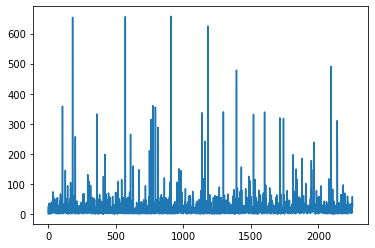

In [96]:
y_pred = model.predict(X_test)
y_pred_denorm = y_pred[:, 0] * (y_reg_max - y_reg_min) + y_reg_min
y_test_denorm = y_test * (y_reg_max - y_reg_min) + y_reg_min
error_denorm = np.abs(y_pred_denorm - y_test_denorm)
plt.plot(range(y_pred.shape[0]), error_denorm)
print(f'Error medio absoluto: {error_denorm.mean()}')

In [97]:
for gt, pred, e in zip(y_test_denorm, y_pred_denorm, error_denorm):
    print(f'Real: {gt:.2f} Predicho: {pred:.2f}. Error: {e:.2f}')

Real: 20.00 Predicho: 20.43. Error: 0.43
Real: 45.00 Predicho: 20.43. Error: 24.57
Real: 25.00 Predicho: 20.43. Error: 4.57
Real: 75.00 Predicho: 64.40. Error: 10.60
Real: 24.00 Predicho: 20.43. Error: 3.57
Real: 62.00 Predicho: 53.08. Error: 8.92
Real: 90.00 Predicho: 89.51. Error: 0.49
Real: 100.00 Predicho: 64.35. Error: 35.65
Real: 50.00 Predicho: 35.53. Error: 14.47
Real: 30.00 Predicho: 24.76. Error: 5.24
Real: 40.00 Predicho: 51.87. Error: 11.87
Real: 30.00 Predicho: 29.64. Error: 0.36
Real: 125.00 Predicho: 103.54. Error: 21.46
Real: 32.00 Predicho: 21.04. Error: 10.96
Real: 30.00 Predicho: 25.17. Error: 4.83
Real: 62.00 Predicho: 27.36. Error: 34.64
Real: 79.00 Predicho: 55.25. Error: 23.75
Real: 32.00 Predicho: 20.43. Error: 11.57
Real: 21.00 Predicho: 20.43. Error: 0.57
Real: 38.00 Predicho: 20.43. Error: 17.57
Real: 45.00 Predicho: 37.83. Error: 7.17
Real: 49.00 Predicho: 27.04. Error: 21.96
Real: 75.00 Predicho: 42.39. Error: 32.61
Real: 88.00 Predicho: 68.85. Error: 19.15

In [98]:
print(f'Error absoluto: {np.mean(error_denorm)}')
print(f'Error cuadrático medio: {np.mean(error_denorm**2)}')

Error absoluto: nan
Error cuadrático medio: nan


EXPLICACION REGRESION NUMERICA --> No consigo entender como no tengo datos en la funcion de activacion pero si me va dando resultados en las predicciones, he probado a usar diferentes funciones de activacion, optimizadores, pero con esta combinacion era la unica que al menos me daba resultado en las predicciones, incluso en las otras pruebas el 'val_loss' tambien me daba siempre 'nan'

**AÑADIMOS IMAGENES**

In [99]:
# creamos un modelo para extraer el vector de características de nuestras imágenes
model_base = VGG16(weights='imagenet', include_top=False)

# creamos un modelo añadiéndole la capa GlobalAveragePooling
x = model_base.output
gap = GlobalAveragePooling2D()(x)
model = Model(inputs=model_base.input, outputs=gap)

model.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
____________________________________________________________

In [100]:
# cuántas imágenes tenemos disponibles?
images.shape

(11268, 224, 224, 3)

In [101]:
from tqdm import tqdm  # para  mostrar el progreso
# vamos a procesarlas y a extraer el vector de 512 características
images_feat = np.zeros((n_images, 512))

for i in tqdm(range(images.shape[0])):
    img = images[i]
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    images_feat[i] = features[0]

100%|██████████| 11268/11268 [01:57<00:00, 95.52it/s] 


In [102]:
images_feat.shape

(11268, 512)

In [103]:
data.shape

(11268, 24)

In [104]:
# Vamos a juntar las features de las imagenes y el dataset numérico/categórico
data_all = np.concatenate((data, images_feat), axis=1)
print(data_all.shape)

(11268, 536)


CLASIFICACION CON IMAGENES

In [105]:
# Vamos a normalizar entre 0 y 1
min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(images_feat)
# en este caso no es necesario normalizar las etiquetas, ya que son valores de 0 a N_Clases

In [106]:
# convertimos las etiquetas a onehot
y_class_onehot = to_categorical(y_class)

# Vamos a dividir en train y en test
X_train, X_test, y_train, y_test = train_test_split(data_norm, y_class_onehot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [107]:
# Creamos un modelo para hacer primero clasificación con y_class
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

loss, acc = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 3s 386us/step - loss: 0.7609 - accuracy: 0.6490 - val_loss: 0.7085 - val_accuracy: 0.6951
Epoch 2/50
8112/8112 [==============================] - 3s 376us/step - loss: 0.7163 - accuracy: 0.6824 - val_loss: 0.7106 - val_accuracy: 0.6863
Epoch 3/50
8112/8112 [==============================] - 3s 380us/step - loss: 0.6921 - accuracy: 0.6877 - val_loss: 0.7086 - val_accuracy: 0.6896
Epoch 4/50
8112/8112 [==============================] - 3s 378us/step - loss: 0.6686 - accuracy: 0.7057 - val_loss: 0.7080 - val_accuracy: 0.6774
Epoch 5/50
8112/8112 [==============================] - 3s 388us/step - loss: 0.6410 - accuracy: 0.7131 - val_loss: 0.7199 - val_accuracy: 0.6807
Epoch 6/50
8112/8112 [==============================] - 3s 412us/step - loss: 0.6142 - accuracy: 0.7269 - val_loss: 0.7186 - val_accuracy: 0.6874
Epoch 7/50
8112/8112 [==============================] - 3s 418us/step - loss:

In [108]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

loss, acc = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 3s 423us/step - loss: 0.7980 - accuracy: 0.6227 - val_loss: 0.7168 - val_accuracy: 0.6918
Epoch 2/50
8112/8112 [==============================] - 3s 427us/step - loss: 0.7398 - accuracy: 0.6665 - val_loss: 0.7001 - val_accuracy: 0.6940
Epoch 3/50
8112/8112 [==============================] - 4s 454us/step - loss: 0.7239 - accuracy: 0.6747 - val_loss: 0.7029 - val_accuracy: 0.6984
Epoch 4/50
8112/8112 [==============================] - 3s 430us/step - loss: 0.7116 - accuracy: 0.6855 - val_loss: 0.7098 - val_accuracy: 0.6752
Epoch 5/50
8112/8112 [==============================] - 3s 416us/step - loss: 0.6911 - accuracy: 0.6953 - val_loss: 0.6885 - val_accuracy: 0.6962
Epoch 6/50
8112/8112 [==============================] - 3s 408us/step - loss: 0.6766 - accuracy: 0.7023 - val_loss: 0.6937 - val_accuracy: 0.6874
Epoch 7/50
8112/8112 [==============================] - 3s 410us/step - loss:

Vamos a probar añadiendo regularización L1.

In [109]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l1(0.003)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=200,
          batch_size=8)

loss, acc = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')

Train on 8112 samples, validate on 902 samples
Epoch 1/200
8112/8112 [==============================] - 4s 479us/step - loss: 1.4077 - accuracy: 0.5152 - val_loss: 0.8843 - val_accuracy: 0.5399
Epoch 2/200
8112/8112 [==============================] - 4s 457us/step - loss: 0.8781 - accuracy: 0.5123 - val_loss: 0.8804 - val_accuracy: 0.5399
Epoch 3/200
8112/8112 [==============================] - 4s 436us/step - loss: 0.8792 - accuracy: 0.5137 - val_loss: 0.8813 - val_accuracy: 0.5399
Epoch 4/200
8112/8112 [==============================] - 4s 433us/step - loss: 0.8785 - accuracy: 0.5154 - val_loss: 0.8807 - val_accuracy: 0.5399
Epoch 5/200
8112/8112 [==============================] - 4s 444us/step - loss: 0.8800 - accuracy: 0.5159 - val_loss: 0.8802 - val_accuracy: 0.5399
Epoch 6/200
8112/8112 [==============================] - 4s 443us/step - loss: 0.8811 - accuracy: 0.5157 - val_loss: 0.8809 - val_accuracy: 0.5399
Epoch 7/200
8112/8112 [==============================] - 4s 432us/step 

EXPLICACION CLASIFICACION CON IMAGENES --> Con las imagenes que tenemos no podemos realizar un buen modelo, seria necesario descargar mas imagenes distintas e intentar como en el ejemplo de Keras que vimos en clase entrenar un modelo con imagenes distintas de X zonas de la vivienda.

**REGRESION CON IMAGENES**

In [110]:
# Normalizamos datos y etiquetas (entre 0 y 1)

min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(images_feat)
y_reg_norm = (y_reg - y_reg.min()) / (y_reg.max() - y_reg.min())

In [111]:
# Vamos a dividir en train y en test
X_train, X_test, y_train, y_test = train_test_split(data_norm, y_reg_norm.values, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [112]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # sin funcion de act y solo 1 neurona

model.compile(loss='mean_absolute_error', optimizer='RMSProp')

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

loss = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 3s 322us/step - loss: nan - val_loss: 0.0347
Epoch 2/50
8112/8112 [==============================] - 3s 335us/step - loss: nan - val_loss: 0.0347
Epoch 3/50
8112/8112 [==============================] - 3s 313us/step - loss: nan - val_loss: 0.0348
Epoch 4/50
8112/8112 [==============================] - 3s 310us/step - loss: nan - val_loss: 0.0341
Epoch 5/50
8112/8112 [==============================] - 3s 310us/step - loss: nan - val_loss: 0.0356
Epoch 6/50
8112/8112 [==============================] - 3s 316us/step - loss: nan - val_loss: 0.0343
Epoch 7/50
8112/8112 [==============================] - 3s 322us/step - loss: nan - val_loss: 0.0348
Epoch 8/50
8112/8112 [==============================] - 3s 345us/step - loss: nan - val_loss: 0.0347
Epoch 9/50
8112/8112 [==============================] - 3s 332us/step - loss: nan - val_loss: 0.0348
Epoch 10/50
8112/8112 [=====================

EXPLICACION REGRESION CON IMAGENES --> He realizado anteriormente varias pruebas con otros optimizadores y funciones de perdida y tampoco consigo que me devuelva valor, me pasa exactamente igual que en el ejemplo numerico.

**CLASIFICACION CON TODOS LOS DATOS**

In [130]:
# Vamos a normalizar entre 0 y 1

min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(data_all)
# en este caso no es necesario normalizar las etiquetas, ya que son valores de 0 a N_Clases.

In [131]:
# convertimos las etiquetas a onehot
y_class_onehot = to_categorical(y_class)

# Vamos a dividir en train y en test
X_train, X_test, y_train, y_test = train_test_split(data_norm, y_class_onehot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [132]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

loss, acc = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 3s 421us/step - loss: 0.6548 - accuracy: 0.7343 - val_loss: 0.5209 - val_accuracy: 0.7882
Epoch 2/50
8112/8112 [==============================] - 3s 415us/step - loss: 0.5353 - accuracy: 0.7965 - val_loss: 0.5032 - val_accuracy: 0.8016
Epoch 3/50
8112/8112 [==============================] - 3s 403us/step - loss: 0.5028 - accuracy: 0.8015 - val_loss: 0.4785 - val_accuracy: 0.7971
Epoch 4/50
8112/8112 [==============================] - 3s 411us/step - loss: 0.4762 - accuracy: 0.8070 - val_loss: 0.4718 - val_accuracy: 0.7993
Epoch 5/50
8112/8112 [==============================] - 4s 449us/step - loss: 0.4643 - accuracy: 0.8135 - val_loss: 0.4729 - val_accuracy: 0.7993
Epoch 6/50
8112/8112 [==============================] - 4s 438us/step - loss: 0.4436 - accuracy: 0.8188 - val_loss: 0.4956 - val_accuracy: 0.7960
Epoch 7/50
8112/8112 [==============================] - 4s 448us/step - loss:

Obtenemos un accuracy mas bajo que con solo datos numericos y creo que es debido a la inclusion de imagenes que hacen empeorar el modelo, como hemos indicado antes si tuvieramos mas imagenes quizas tambien este modelo mejoraria.

**REGRESION CON TODOS LOS DATOS**

In [133]:
# Normalizamos datos y etiquetas entre 0 y 1

min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(data_all)
y_reg_norm = (y_reg - y_reg.min()) / (y_reg.max() - y_reg.min())

In [134]:
X_train, X_test, y_train, y_test = train_test_split(data_norm, y_reg_norm.values, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [140]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # sin funcion de act y solo 1 neurona

model.compile(loss='mean_absolute_error', optimizer='RMSProp')

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

Train on 8112 samples, validate on 902 samples
Epoch 1/50
8112/8112 [==============================] - 2s 283us/step - loss: nan - val_loss: 0.0276
Epoch 2/50
8112/8112 [==============================] - 2s 281us/step - loss: nan - val_loss: 0.0248
Epoch 3/50
8112/8112 [==============================] - 2s 278us/step - loss: nan - val_loss: 0.0244
Epoch 4/50
8112/8112 [==============================] - 2s 274us/step - loss: nan - val_loss: 0.0247
Epoch 5/50
8112/8112 [==============================] - 2s 282us/step - loss: nan - val_loss: 0.0241
Epoch 6/50
8112/8112 [==============================] - 2s 282us/step - loss: nan - val_loss: 0.0238
Epoch 7/50
8112/8112 [==============================] - 2s 285us/step - loss: nan - val_loss: 0.0239
Epoch 8/50
8112/8112 [==============================] - 2s 276us/step - loss: nan - val_loss: 0.0261
Epoch 9/50
8112/8112 [==============================] - 2s 277us/step - loss: nan - val_loss: 0.0241
Epoch 10/50
8112/8112 [=====================

In [141]:
loss = model.evaluate(X_test, y_test)
print(f'Loss={loss}')

2254/2254 [==============================] - 0s 38us/step
Loss=nan


In [142]:
y_reg_min = y_reg.min()
y_reg_max = y_reg.max()

Error medio absoluto: nan


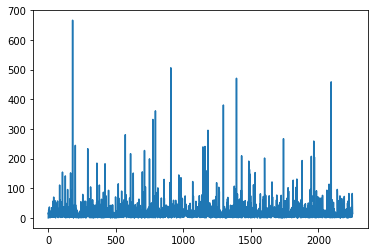

In [143]:
y_pred = model.predict(X_test)
y_pred_denorm = y_pred[:, 0] * (y_reg_max - y_reg_min) + y_reg_min
y_test_denorm = y_test * (y_reg_max - y_reg_min) + y_reg_min
error_denorm = np.abs(y_pred_denorm - y_test_denorm)
plt.plot(range(y_pred.shape[0]), error_denorm)
print(f'Error medio absoluto: {error_denorm.mean()}')

In [144]:
for gt, pred, e in zip(y_test_denorm, y_pred_denorm, error_denorm):
    print(f'Real: {gt:.2f} Predicho: {pred:.2f}. Error: {e:.2f}')

Real: 20.00 Predicho: 20.24. Error: 0.24
Real: 45.00 Predicho: 27.20. Error: 17.80
Real: 25.00 Predicho: 36.85. Error: 11.85
Real: 75.00 Predicho: 48.04. Error: 26.96
Real: 24.00 Predicho: 18.98. Error: 5.02
Real: 62.00 Predicho: 66.03. Error: 4.03
Real: 90.00 Predicho: 118.99. Error: 28.99
Real: 100.00 Predicho: 88.91. Error: 11.09
Real: 50.00 Predicho: 86.81. Error: 36.81
Real: 30.00 Predicho: 36.55. Error: 6.55
Real: 40.00 Predicho: 53.03. Error: 13.03
Real: 30.00 Predicho: 39.95. Error: 9.95
Real: 125.00 Predicho: 125.43. Error: 0.43
Real: 32.00 Predicho: 27.41. Error: 4.59
Real: 30.00 Predicho: 33.61. Error: 3.61
Real: 62.00 Predicho: 39.23. Error: 22.77
Real: 79.00 Predicho: 74.97. Error: 4.03
Real: 32.00 Predicho: 33.61. Error: 1.61
Real: 21.00 Predicho: 25.01. Error: 4.01
Real: 38.00 Predicho: 23.50. Error: 14.50
Real: 45.00 Predicho: 47.95. Error: 2.95
Real: 49.00 Predicho: 59.53. Error: 10.53
Real: 75.00 Predicho: 57.53. Error: 17.47
Real: 88.00 Predicho: 70.65. Error: 17.35


In [145]:
print(f'Error absoluto: {np.mean(error_denorm)}')
print(f'Error cuadrático medio: {np.mean(error_denorm**2)}')

Error absoluto: nan
Error cuadrático medio: nan


EXPLICACION REGRESION CON TODOS LOS DATOS --> Y tampoco consigo aqui por mas cosas que pruebo, dar en el fallo que cometo con la funcion de perdidas en regresion.

Esto era lo que me pasaba antes de entregar la practica y no he podido dar con ello, si ejecutaba el ejemplo que has subido con los datos que tenia yo tambien me daba error, quizas he cometido algun error que desconozo y no he podido localizar.